<a href="https://colab.research.google.com/github/TheAmirHK/Financial-market-analysis/blob/main/Stock%20price%20forecasting_Regression_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
from datetime import datetime, date, timedelta
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from tqdm import tqdm

# For warnings suppression
import warnings
warnings.filterwarnings("ignore")

In [2]:
# The stocks to be analyzed !
stock = ["AAPL"]

# define the number of year to be studied
NYears = 5

# Define the time period of study
end = datetime.today()
start = end - timedelta(days = NYears*365)
# Download stock data
data = pdr.get_data_yahoo(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Split train and test dataset and scale the sets
def split_data_scaled (data , test_size= None):
    input = pd.DataFrame(data)
    input = input.reset_index(drop=True)
    Xtrain_set = np.array(input.Open).reshape(-1, 1)
    Ytrain_set = np.array(input['Adj Close']).reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_dataset = scaler.fit_transform(Ytrain_set)
    X_train, X_test, y_train, y_test = train_test_split(Xtrain_set, scaled_dataset, test_size=test_size, shuffle=False)
    return X_train, X_test, y_train, y_test, scaler


In [4]:
# Introduce regression models to be fitted
def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(DecisionTreeRegressor(max_depth=100))
    models.append(KNeighborsRegressor())
    models.append(BaggingRegressor(n_estimators=100))
    models.append(RandomForestRegressor(n_estimators=1000))
    return models

In [5]:
# Evalute the the fitted models
def evaluate_models(inputs, outputs, models, scaler):
    MAPE_list = pd.DataFrame()
    valids_ = np.stack((X_valid, y_valid), axis=1)
    valids_ = np.sort(valids_, axis = 0)
    inputs = valids_[:,0]
    outputs = valids_[:,1]
    for model in models:
        yhat = model.predict(inputs)
        yhat = yhat.reshape(-1,1)
        outputs = outputs.reshape(-1,1)
        outputs_ = scaler.inverse_transform(outputs)
        yhat_ = scaler.inverse_transform(yhat)

        accuracy = mean_absolute_percentage_error(outputs_, yhat_)
        MAPE_list[model.__class__.__name__] = [accuracy]
        plt.plot(inputs , yhat_, label="%s" %model.__class__.__name__)
    plt.plot(inputs , outputs_, "--", label="Real data")
    plt.xlabel('Opening price')
    plt.ylabel('Adjusted close price')
    plt.legend(fontsize="8", loc ="upper left")
    return MAPE_list


In [6]:
""" Using regression methods such as LinearRegression, DecisionTreeRegressor, KNeighborsRegressor, etc. to forecast the future price of a stock.
An effecient regression mehtod can predic the future price of a stock using the opening price of the same stock. Therefore , it can be presented as follow:
ŷ = f(opening price) where ŷ indicates the future value and f represents the regression model.
"""
# Fit the models
def fit_base_models(X, y, models):
	for model in models:
	    model.fit(X, y)

,LinearRegression,DecisionTreeRegressor,KNeighborsRegressor,BaggingRegressor,RandomForestRegressor
0,0.006011,0.01046,0.011469,0.008834,0.008673


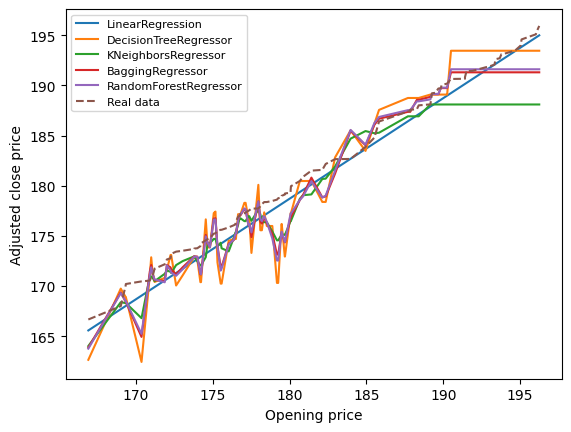

In [7]:
models = get_models()
X_train, X_valid, y_train, y_valid, scaler = split_data_scaled (data , test_size= 0.08)
fit_base_models(X_train, y_train, models)
reg_MAPE_list = evaluate_models(X_valid, y_valid, models, scaler)
reg_MAPE_list